# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of $radiological images$ with contrast and without contrast

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_contrast.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.


It may be named `patient` with a dash or an underscore, so take note and make sure the below `image_dir` accordingly. Then you can proceed with the following loading code.

In [1]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

from config import Params

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `ConContraste` or `SinContraste`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [2]:
def get_data_loader(image_type, image_dir=Params.path_jpg,
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    #image_path = './' + image_dir
    image_path = image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='SIMPLE')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='ANGIO')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

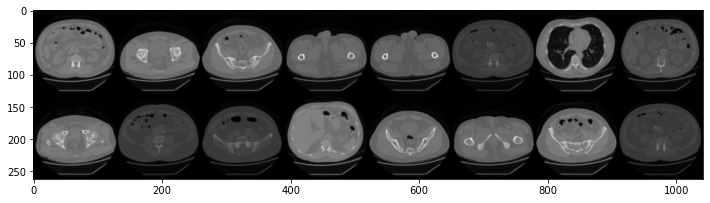

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

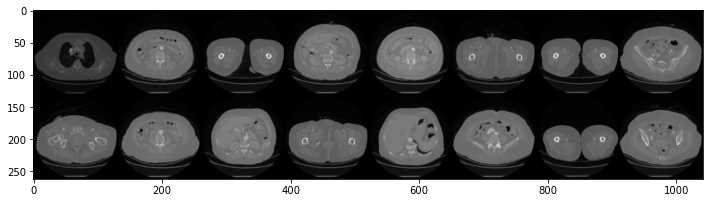

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(0.5020)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(0.0039)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [11]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [13]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [14]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [16]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.

In [17]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [18]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [19]:
# import save code
from helpers import save_samples, checkpoint

In [20]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [21]:
n_epochs = 4000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.1876 | d_Y_loss: 0.1947 | g_total_loss: 11.8201
Epoch [   20/ 4000] | d_X_loss: 0.1962 | d_Y_loss: 0.1772 | g_total_loss: 9.0591
Epoch [   30/ 4000] | d_X_loss: 0.0590 | d_Y_loss: 0.2211 | g_total_loss: 8.0800
Epoch [   40/ 4000] | d_X_loss: 0.0889 | d_Y_loss: 0.0333 | g_total_loss: 5.7219
Epoch [   50/ 4000] | d_X_loss: 0.0901 | d_Y_loss: 0.0942 | g_total_loss: 4.8565
Epoch [   60/ 4000] | d_X_loss: 0.0656 | d_Y_loss: 0.0738 | g_total_loss: 5.2628
Epoch [   70/ 4000] | d_X_loss: 0.0550 | d_Y_loss: 1.0782 | g_total_loss: 4.4035
Epoch [   80/ 4000] | d_X_loss: 0.2317 | d_Y_loss: 0.3318 | g_total_loss: 3.3946
Epoch [   90/ 4000] | d_X_loss: 0.1860 | d_Y_loss: 0.4030 | g_total_loss: 3.7682


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/ 4000] | d_X_loss: 0.3047 | d_Y_loss: 0.3003 | g_total_loss: 4.0294


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-000100-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.2232 | d_Y_loss: 0.3067 | g_total_loss: 3.0826
Epoch [  120/ 4000] | d_X_loss: 0.5503 | d_Y_loss: 0.2631 | g_total_loss: 4.9684
Epoch [  130/ 4000] | d_X_loss: 0.2956 | d_Y_loss: 0.8599 | g_total_loss: 3.8212
Epoch [  140/ 4000] | d_X_loss: 0.2142 | d_Y_loss: 0.3244 | g_total_loss: 2.8804
Epoch [  150/ 4000] | d_X_loss: 0.3342 | d_Y_loss: 0.9219 | g_total_loss: 3.1802
Epoch [  160/ 4000] | d_X_loss: 0.2491 | d_Y_loss: 0.3105 | g_total_loss: 3.3484
Epoch [  170/ 4000] | d_X_loss: 0.2539 | d_Y_loss: 0.3629 | g_total_loss: 3.1347
Epoch [  180/ 4000] | d_X_loss: 0.3012 | d_Y_loss: 0.2802 | g_total_loss: 2.1856
Epoch [  190/ 4000] | d_X_loss: 0.4572 | d_Y_loss: 0.2422 | g_total_loss: 3.0260


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/ 4000] | d_X_loss: 0.3212 | d_Y_loss: 0.2789 | g_total_loss: 2.4278


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-000200-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.8793 | d_Y_loss: 0.3003 | g_total_loss: 2.9938
Epoch [  220/ 4000] | d_X_loss: 0.3214 | d_Y_loss: 0.2367 | g_total_loss: 2.6180
Epoch [  230/ 4000] | d_X_loss: 0.2495 | d_Y_loss: 0.5304 | g_total_loss: 3.0390
Epoch [  240/ 4000] | d_X_loss: 0.2284 | d_Y_loss: 0.1902 | g_total_loss: 3.1137
Epoch [  250/ 4000] | d_X_loss: 0.4706 | d_Y_loss: 0.3170 | g_total_loss: 3.1165
Epoch [  260/ 4000] | d_X_loss: 0.2536 | d_Y_loss: 0.3667 | g_total_loss: 2.3252
Epoch [  270/ 4000] | d_X_loss: 0.2249 | d_Y_loss: 0.3744 | g_total_loss: 3.2133
Epoch [  280/ 4000] | d_X_loss: 0.3711 | d_Y_loss: 0.4340 | g_total_loss: 2.0606
Epoch [  290/ 4000] | d_X_loss: 0.2123 | d_Y_loss: 0.2142 | g_total_loss: 2.4497


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  300/ 4000] | d_X_loss: 0.3172 | d_Y_loss: 0.5735 | g_total_loss: 2.9324


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-000300-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.3706 | d_Y_loss: 0.4574 | g_total_loss: 2.4020
Epoch [  320/ 4000] | d_X_loss: 0.2997 | d_Y_loss: 0.4287 | g_total_loss: 2.8077
Epoch [  330/ 4000] | d_X_loss: 0.2824 | d_Y_loss: 0.4204 | g_total_loss: 1.9119
Epoch [  340/ 4000] | d_X_loss: 0.3130 | d_Y_loss: 0.4280 | g_total_loss: 2.0323
Epoch [  350/ 4000] | d_X_loss: 0.2610 | d_Y_loss: 0.4058 | g_total_loss: 2.2577
Epoch [  360/ 4000] | d_X_loss: 0.2655 | d_Y_loss: 0.3273 | g_total_loss: 2.2253
Epoch [  370/ 4000] | d_X_loss: 0.1777 | d_Y_loss: 0.4312 | g_total_loss: 1.7530
Epoch [  380/ 4000] | d_X_loss: 0.3317 | d_Y_loss: 0.3264 | g_total_loss: 1.7660
Epoch [  390/ 4000] | d_X_loss: 0.3008 | d_Y_loss: 0.3782 | g_total_loss: 2.2221


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  400/ 4000] | d_X_loss: 0.2498 | d_Y_loss: 0.2807 | g_total_loss: 2.2117


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-000400-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.2765 | d_Y_loss: 0.1991 | g_total_loss: 2.3877
Epoch [  420/ 4000] | d_X_loss: 0.2458 | d_Y_loss: 0.2537 | g_total_loss: 1.7247
Epoch [  430/ 4000] | d_X_loss: 0.2318 | d_Y_loss: 0.3691 | g_total_loss: 2.5869
Epoch [  440/ 4000] | d_X_loss: 0.2267 | d_Y_loss: 0.3268 | g_total_loss: 2.3773
Epoch [  450/ 4000] | d_X_loss: 0.2921 | d_Y_loss: 0.2614 | g_total_loss: 2.1314
Epoch [  460/ 4000] | d_X_loss: 0.2626 | d_Y_loss: 0.2749 | g_total_loss: 1.9547
Epoch [  470/ 4000] | d_X_loss: 0.5683 | d_Y_loss: 0.2600 | g_total_loss: 2.4074
Epoch [  480/ 4000] | d_X_loss: 0.3179 | d_Y_loss: 0.4213 | g_total_loss: 2.2140
Epoch [  490/ 4000] | d_X_loss: 0.2759 | d_Y_loss: 0.2283 | g_total_loss: 2.2466


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  500/ 4000] | d_X_loss: 0.2601 | d_Y_loss: 0.6129 | g_total_loss: 2.6884


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-000500-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.2499 | d_Y_loss: 0.1866 | g_total_loss: 1.6956
Epoch [  520/ 4000] | d_X_loss: 0.3016 | d_Y_loss: 0.3249 | g_total_loss: 2.7795
Epoch [  530/ 4000] | d_X_loss: 0.2545 | d_Y_loss: 0.4136 | g_total_loss: 2.0726
Epoch [  540/ 4000] | d_X_loss: 0.2440 | d_Y_loss: 0.6532 | g_total_loss: 2.9938
Epoch [  550/ 4000] | d_X_loss: 0.1711 | d_Y_loss: 0.1917 | g_total_loss: 2.4285
Epoch [  560/ 4000] | d_X_loss: 0.2512 | d_Y_loss: 0.3297 | g_total_loss: 2.7661
Epoch [  570/ 4000] | d_X_loss: 0.1964 | d_Y_loss: 0.5576 | g_total_loss: 2.1576
Epoch [  580/ 4000] | d_X_loss: 0.6672 | d_Y_loss: 0.2055 | g_total_loss: 3.0432
Epoch [  590/ 4000] | d_X_loss: 0.2578 | d_Y_loss: 0.2349 | g_total_loss: 2.4293


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  600/ 4000] | d_X_loss: 0.3290 | d_Y_loss: 0.2772 | g_total_loss: 1.8889


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-000600-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.1085 | d_Y_loss: 0.3030 | g_total_loss: 2.3226
Epoch [  620/ 4000] | d_X_loss: 0.2563 | d_Y_loss: 0.2637 | g_total_loss: 3.0307
Epoch [  630/ 4000] | d_X_loss: 0.2188 | d_Y_loss: 0.2336 | g_total_loss: 1.8877
Epoch [  640/ 4000] | d_X_loss: 0.2200 | d_Y_loss: 0.3517 | g_total_loss: 2.8846
Epoch [  650/ 4000] | d_X_loss: 0.5007 | d_Y_loss: 0.2790 | g_total_loss: 1.7578
Epoch [  660/ 4000] | d_X_loss: 0.2375 | d_Y_loss: 0.1498 | g_total_loss: 2.5583
Epoch [  670/ 4000] | d_X_loss: 0.1633 | d_Y_loss: 0.2851 | g_total_loss: 1.7926
Epoch [  680/ 4000] | d_X_loss: 0.1908 | d_Y_loss: 0.4419 | g_total_loss: 2.7558
Epoch [  690/ 4000] | d_X_loss: 0.1967 | d_Y_loss: 0.1572 | g_total_loss: 2.4366


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  700/ 4000] | d_X_loss: 0.4825 | d_Y_loss: 0.4109 | g_total_loss: 2.5766


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-000700-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.1426 | d_Y_loss: 0.2948 | g_total_loss: 2.3780
Epoch [  720/ 4000] | d_X_loss: 0.2353 | d_Y_loss: 0.2008 | g_total_loss: 1.9002
Epoch [  730/ 4000] | d_X_loss: 0.3255 | d_Y_loss: 0.2379 | g_total_loss: 2.4806
Epoch [  740/ 4000] | d_X_loss: 0.2177 | d_Y_loss: 0.3406 | g_total_loss: 1.8520
Epoch [  750/ 4000] | d_X_loss: 0.1703 | d_Y_loss: 0.1366 | g_total_loss: 2.4954
Epoch [  760/ 4000] | d_X_loss: 0.1349 | d_Y_loss: 0.2601 | g_total_loss: 2.0707
Epoch [  770/ 4000] | d_X_loss: 0.3062 | d_Y_loss: 0.3354 | g_total_loss: 2.6615
Epoch [  780/ 4000] | d_X_loss: 0.2007 | d_Y_loss: 0.3204 | g_total_loss: 3.1003
Epoch [  790/ 4000] | d_X_loss: 0.2915 | d_Y_loss: 0.2942 | g_total_loss: 2.1078


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  800/ 4000] | d_X_loss: 0.2032 | d_Y_loss: 0.2190 | g_total_loss: 2.5750


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-000800-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.2573 | d_Y_loss: 0.3064 | g_total_loss: 3.0589
Epoch [  820/ 4000] | d_X_loss: 0.3627 | d_Y_loss: 0.1710 | g_total_loss: 2.9075
Epoch [  830/ 4000] | d_X_loss: 0.2854 | d_Y_loss: 0.2994 | g_total_loss: 2.0920
Epoch [  840/ 4000] | d_X_loss: 0.6046 | d_Y_loss: 0.2497 | g_total_loss: 2.3572
Epoch [  850/ 4000] | d_X_loss: 0.2205 | d_Y_loss: 0.1856 | g_total_loss: 2.0045
Epoch [  860/ 4000] | d_X_loss: 0.3870 | d_Y_loss: 0.1884 | g_total_loss: 2.3553
Epoch [  870/ 4000] | d_X_loss: 0.2488 | d_Y_loss: 0.2109 | g_total_loss: 1.6984
Epoch [  880/ 4000] | d_X_loss: 0.1675 | d_Y_loss: 0.2046 | g_total_loss: 2.4686
Epoch [  890/ 4000] | d_X_loss: 0.3965 | d_Y_loss: 0.2204 | g_total_loss: 3.0039


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/ 4000] | d_X_loss: 0.4959 | d_Y_loss: 2.7408 | g_total_loss: 3.5086


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-000900-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.2841 | d_Y_loss: 0.4008 | g_total_loss: 2.5026
Epoch [  920/ 4000] | d_X_loss: 0.2110 | d_Y_loss: 0.4005 | g_total_loss: 1.6048
Epoch [  930/ 4000] | d_X_loss: 0.2646 | d_Y_loss: 0.3915 | g_total_loss: 2.4261
Epoch [  940/ 4000] | d_X_loss: 0.1894 | d_Y_loss: 0.3560 | g_total_loss: 1.9164
Epoch [  950/ 4000] | d_X_loss: 0.2765 | d_Y_loss: 0.3264 | g_total_loss: 2.1899
Epoch [  960/ 4000] | d_X_loss: 0.3275 | d_Y_loss: 0.3859 | g_total_loss: 3.3019
Epoch [  970/ 4000] | d_X_loss: 0.1792 | d_Y_loss: 0.3146 | g_total_loss: 2.2150
Epoch [  980/ 4000] | d_X_loss: 0.1954 | d_Y_loss: 0.2971 | g_total_loss: 1.6046
Epoch [  990/ 4000] | d_X_loss: 0.0683 | d_Y_loss: 0.2527 | g_total_loss: 2.2481


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/ 4000] | d_X_loss: 0.3000 | d_Y_loss: 0.4969 | g_total_loss: 2.3919


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-001000-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.2642 | d_Y_loss: 0.2402 | g_total_loss: 1.8220
Epoch [ 1020/ 4000] | d_X_loss: 0.1852 | d_Y_loss: 0.2765 | g_total_loss: 1.8162
Epoch [ 1030/ 4000] | d_X_loss: 0.3919 | d_Y_loss: 0.6797 | g_total_loss: 1.8352
Epoch [ 1040/ 4000] | d_X_loss: 0.3153 | d_Y_loss: 0.3324 | g_total_loss: 1.6691
Epoch [ 1050/ 4000] | d_X_loss: 0.2478 | d_Y_loss: 0.2185 | g_total_loss: 2.0068
Epoch [ 1060/ 4000] | d_X_loss: 0.3042 | d_Y_loss: 0.2223 | g_total_loss: 2.0775
Epoch [ 1070/ 4000] | d_X_loss: 0.1694 | d_Y_loss: 0.2512 | g_total_loss: 2.3487
Epoch [ 1080/ 4000] | d_X_loss: 0.2058 | d_Y_loss: 0.1657 | g_total_loss: 2.5956
Epoch [ 1090/ 4000] | d_X_loss: 1.3906 | d_Y_loss: 0.2166 | g_total_loss: 2.4656


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1100/ 4000] | d_X_loss: 0.4107 | d_Y_loss: 0.2215 | g_total_loss: 2.1171


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-001100-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.2164 | d_Y_loss: 0.2479 | g_total_loss: 1.8293
Epoch [ 1120/ 4000] | d_X_loss: 0.2196 | d_Y_loss: 0.3256 | g_total_loss: 2.1732
Epoch [ 1130/ 4000] | d_X_loss: 0.2155 | d_Y_loss: 0.1679 | g_total_loss: 1.8277
Epoch [ 1140/ 4000] | d_X_loss: 0.1924 | d_Y_loss: 0.1743 | g_total_loss: 2.5059
Epoch [ 1150/ 4000] | d_X_loss: 0.3030 | d_Y_loss: 0.2347 | g_total_loss: 1.9468
Epoch [ 1160/ 4000] | d_X_loss: 0.1807 | d_Y_loss: 0.3131 | g_total_loss: 2.3251
Epoch [ 1170/ 4000] | d_X_loss: 0.2200 | d_Y_loss: 0.2167 | g_total_loss: 1.8816
Epoch [ 1180/ 4000] | d_X_loss: 0.2078 | d_Y_loss: 0.1693 | g_total_loss: 2.1591
Epoch [ 1190/ 4000] | d_X_loss: 0.2516 | d_Y_loss: 0.2112 | g_total_loss: 1.8573


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1200/ 4000] | d_X_loss: 0.1399 | d_Y_loss: 0.4559 | g_total_loss: 1.7345


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-001200-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.1268 | d_Y_loss: 0.4118 | g_total_loss: 2.0176
Epoch [ 1220/ 4000] | d_X_loss: 0.1891 | d_Y_loss: 0.1247 | g_total_loss: 2.1288
Epoch [ 1230/ 4000] | d_X_loss: 0.4128 | d_Y_loss: 0.2223 | g_total_loss: 2.4089
Epoch [ 1240/ 4000] | d_X_loss: 0.2272 | d_Y_loss: 0.4576 | g_total_loss: 2.8867
Epoch [ 1250/ 4000] | d_X_loss: 0.3277 | d_Y_loss: 0.2253 | g_total_loss: 2.0334
Epoch [ 1260/ 4000] | d_X_loss: 0.1259 | d_Y_loss: 0.4165 | g_total_loss: 2.8494
Epoch [ 1270/ 4000] | d_X_loss: 0.6306 | d_Y_loss: 0.2179 | g_total_loss: 3.6361
Epoch [ 1280/ 4000] | d_X_loss: 0.2735 | d_Y_loss: 0.1735 | g_total_loss: 1.9180
Epoch [ 1290/ 4000] | d_X_loss: 0.2729 | d_Y_loss: 0.5092 | g_total_loss: 2.8109


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1300/ 4000] | d_X_loss: 0.1328 | d_Y_loss: 0.2322 | g_total_loss: 1.8978


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-001300-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.1538 | d_Y_loss: 0.2017 | g_total_loss: 1.8860
Epoch [ 1320/ 4000] | d_X_loss: 0.3676 | d_Y_loss: 0.3277 | g_total_loss: 1.8566
Epoch [ 1330/ 4000] | d_X_loss: 0.1627 | d_Y_loss: 0.4501 | g_total_loss: 1.3912
Epoch [ 1340/ 4000] | d_X_loss: 0.1314 | d_Y_loss: 0.2147 | g_total_loss: 1.7482
Epoch [ 1350/ 4000] | d_X_loss: 0.4225 | d_Y_loss: 0.2918 | g_total_loss: 2.2060
Epoch [ 1360/ 4000] | d_X_loss: 0.1865 | d_Y_loss: 2.6503 | g_total_loss: 4.9172
Epoch [ 1370/ 4000] | d_X_loss: 0.2872 | d_Y_loss: 0.5134 | g_total_loss: 1.5880
Epoch [ 1380/ 4000] | d_X_loss: 0.2107 | d_Y_loss: 0.5024 | g_total_loss: 1.9510
Epoch [ 1390/ 4000] | d_X_loss: 0.1426 | d_Y_loss: 0.4802 | g_total_loss: 1.6802


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1400/ 4000] | d_X_loss: 0.3461 | d_Y_loss: 0.5252 | g_total_loss: 1.2788


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-001400-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.1782 | d_Y_loss: 0.4931 | g_total_loss: 1.7863
Epoch [ 1420/ 4000] | d_X_loss: 0.2419 | d_Y_loss: 0.5233 | g_total_loss: 1.8563
Epoch [ 1430/ 4000] | d_X_loss: 0.1977 | d_Y_loss: 0.4858 | g_total_loss: 1.8372
Epoch [ 1440/ 4000] | d_X_loss: 0.3338 | d_Y_loss: 0.4898 | g_total_loss: 1.3156
Epoch [ 1450/ 4000] | d_X_loss: 0.4227 | d_Y_loss: 0.4904 | g_total_loss: 1.9100
Epoch [ 1460/ 4000] | d_X_loss: 0.1292 | d_Y_loss: 0.4741 | g_total_loss: 1.4791
Epoch [ 1470/ 4000] | d_X_loss: 0.2184 | d_Y_loss: 0.4651 | g_total_loss: 1.6104
Epoch [ 1480/ 4000] | d_X_loss: 0.0973 | d_Y_loss: 0.4405 | g_total_loss: 2.2948
Epoch [ 1490/ 4000] | d_X_loss: 0.4515 | d_Y_loss: 0.4684 | g_total_loss: 2.5581


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1500/ 4000] | d_X_loss: 0.1592 | d_Y_loss: 0.4415 | g_total_loss: 1.4500


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-001500-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.2714 | d_Y_loss: 0.5143 | g_total_loss: 1.7977
Epoch [ 1520/ 4000] | d_X_loss: 0.4076 | d_Y_loss: 0.4793 | g_total_loss: 1.3336
Epoch [ 1530/ 4000] | d_X_loss: 0.4223 | d_Y_loss: 0.4374 | g_total_loss: 1.9384
Epoch [ 1540/ 4000] | d_X_loss: 0.2050 | d_Y_loss: 0.4493 | g_total_loss: 1.5400
Epoch [ 1550/ 4000] | d_X_loss: 0.2559 | d_Y_loss: 0.4793 | g_total_loss: 1.9703
Epoch [ 1560/ 4000] | d_X_loss: 0.2051 | d_Y_loss: 0.4270 | g_total_loss: 1.4200
Epoch [ 1570/ 4000] | d_X_loss: 0.1401 | d_Y_loss: 0.4123 | g_total_loss: 1.9422
Epoch [ 1580/ 4000] | d_X_loss: 0.6320 | d_Y_loss: 0.3946 | g_total_loss: 1.9187
Epoch [ 1590/ 4000] | d_X_loss: 0.2603 | d_Y_loss: 0.3656 | g_total_loss: 1.3574


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1600/ 4000] | d_X_loss: 0.2359 | d_Y_loss: 0.4133 | g_total_loss: 1.4850


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-001600-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-001600-Y-X.png
Epoch [ 1610/ 4000] | d_X_loss: 0.2794 | d_Y_loss: 0.3512 | g_total_loss: 1.7778
Epoch [ 1620/ 4000] | d_X_loss: 0.6719 | d_Y_loss: 0.3444 | g_total_loss: 1.5933
Epoch [ 1630/ 4000] | d_X_loss: 0.5247 | d_Y_loss: 0.3771 | g_total_loss: 1.3493
Epoch [ 1640/ 4000] | d_X_loss: 0.3838 | d_Y_loss: 0.3902 | g_total_loss: 1.5937
Epoch [ 1650/ 4000] | d_X_loss: 0.3041 | d_Y_loss: 0.3236 | g_total_loss: 1.9536
Epoch [ 1660/ 4000] | d_X_loss: 0.2672 | d_Y_loss: 0.3391 | g_total_loss: 1.6070
Epoch [ 1670/ 4000] | d_X_loss: 0.2409 | d_Y_loss: 0.2780 | g_total_loss: 1.8319
Epoch [ 1680/ 4000] | d_X_loss: 0.2354 | d_Y_loss: 0.2797 | g_total_loss: 1.8382
Epoch [ 1690/ 4000] | d_X_loss: 0.2696 | d_Y_loss: 0.3864 | g_total_loss: 1.9176


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1700/ 4000] | d_X_loss: 0.3430 | d_Y_loss: 0.3630 | g_total_loss: 2.0696


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-001700-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-001700-Y-X.png
Epoch [ 1710/ 4000] | d_X_loss: 0.1605 | d_Y_loss: 1.1812 | g_total_loss: 1.9501
Epoch [ 1720/ 4000] | d_X_loss: 0.2751 | d_Y_loss: 0.2503 | g_total_loss: 1.6667
Epoch [ 1730/ 4000] | d_X_loss: 0.7480 | d_Y_loss: 0.3311 | g_total_loss: 2.3681
Epoch [ 1740/ 4000] | d_X_loss: 0.2362 | d_Y_loss: 0.2002 | g_total_loss: 2.1029
Epoch [ 1750/ 4000] | d_X_loss: 0.1821 | d_Y_loss: 0.1466 | g_total_loss: 2.0577
Epoch [ 1760/ 4000] | d_X_loss: 0.1405 | d_Y_loss: 0.3432 | g_total_loss: 2.4975
Epoch [ 1770/ 4000] | d_X_loss: 0.3666 | d_Y_loss: 0.2908 | g_total_loss: 2.1539
Epoch [ 1780/ 4000] | d_X_loss: 0.1581 | d_Y_loss: 0.2566 | g_total_loss: 1.7437
Epoch [ 1790/ 4000] | d_X_loss: 0.2895 | d_Y_loss: 0.2332 | g_total_loss: 1.5364


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1800/ 4000] | d_X_loss: 0.5633 | d_Y_loss: 0.2159 | g_total_loss: 3.0924


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-001800-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-001800-Y-X.png
Epoch [ 1810/ 4000] | d_X_loss: 0.2298 | d_Y_loss: 0.1616 | g_total_loss: 1.6621
Epoch [ 1820/ 4000] | d_X_loss: 0.1796 | d_Y_loss: 0.1549 | g_total_loss: 1.9944
Epoch [ 1830/ 4000] | d_X_loss: 0.6297 | d_Y_loss: 1.1260 | g_total_loss: 2.2717
Epoch [ 1840/ 4000] | d_X_loss: 0.3123 | d_Y_loss: 0.2294 | g_total_loss: 2.0360
Epoch [ 1850/ 4000] | d_X_loss: 0.3090 | d_Y_loss: 0.1771 | g_total_loss: 1.3363
Epoch [ 1860/ 4000] | d_X_loss: 0.2268 | d_Y_loss: 1.0901 | g_total_loss: 3.1828
Epoch [ 1870/ 4000] | d_X_loss: 0.3413 | d_Y_loss: 0.2434 | g_total_loss: 1.5643
Epoch [ 1880/ 4000] | d_X_loss: 0.3550 | d_Y_loss: 0.2644 | g_total_loss: 1.4567
Epoch [ 1890/ 4000] | d_X_loss: 1.5731 | d_Y_loss: 0.2466 | g_total_loss: 3.4304


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1900/ 4000] | d_X_loss: 0.5087 | d_Y_loss: 0.2421 | g_total_loss: 1.7207


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-001900-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-001900-Y-X.png
Epoch [ 1910/ 4000] | d_X_loss: 0.4043 | d_Y_loss: 0.1962 | g_total_loss: 1.5852
Epoch [ 1920/ 4000] | d_X_loss: 0.2407 | d_Y_loss: 0.2997 | g_total_loss: 1.7170
Epoch [ 1930/ 4000] | d_X_loss: 0.3577 | d_Y_loss: 0.2072 | g_total_loss: 3.1736
Epoch [ 1940/ 4000] | d_X_loss: 0.2851 | d_Y_loss: 0.2402 | g_total_loss: 1.7870
Epoch [ 1950/ 4000] | d_X_loss: 0.3780 | d_Y_loss: 0.2171 | g_total_loss: 1.6003
Epoch [ 1960/ 4000] | d_X_loss: 0.2483 | d_Y_loss: 0.4480 | g_total_loss: 2.5964
Epoch [ 1970/ 4000] | d_X_loss: 0.4167 | d_Y_loss: 0.3208 | g_total_loss: 1.4187
Epoch [ 1980/ 4000] | d_X_loss: 0.3022 | d_Y_loss: 0.2404 | g_total_loss: 1.8514
Epoch [ 1990/ 4000] | d_X_loss: 0.2162 | d_Y_loss: 0.3516 | g_total_loss: 1.5467


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/ 4000] | d_X_loss: 0.3101 | d_Y_loss: 0.2848 | g_total_loss: 2.1622


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-002000-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-002000-Y-X.png
Epoch [ 2010/ 4000] | d_X_loss: 0.2762 | d_Y_loss: 0.4426 | g_total_loss: 3.0979
Epoch [ 2020/ 4000] | d_X_loss: 0.2230 | d_Y_loss: 0.3942 | g_total_loss: 1.8781
Epoch [ 2030/ 4000] | d_X_loss: 0.4169 | d_Y_loss: 0.2341 | g_total_loss: 1.8367
Epoch [ 2040/ 4000] | d_X_loss: 0.2300 | d_Y_loss: 0.2448 | g_total_loss: 1.9409
Epoch [ 2050/ 4000] | d_X_loss: 0.5084 | d_Y_loss: 0.2225 | g_total_loss: 2.3329
Epoch [ 2060/ 4000] | d_X_loss: 0.3592 | d_Y_loss: 0.1638 | g_total_loss: 2.9162
Epoch [ 2070/ 4000] | d_X_loss: 0.2754 | d_Y_loss: 0.2787 | g_total_loss: 1.6091
Epoch [ 2080/ 4000] | d_X_loss: 0.3817 | d_Y_loss: 0.1920 | g_total_loss: 2.2122
Epoch [ 2090/ 4000] | d_X_loss: 0.2174 | d_Y_loss: 0.3653 | g_total_loss: 1.6551


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2100/ 4000] | d_X_loss: 0.4157 | d_Y_loss: 0.2252 | g_total_loss: 1.7384


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-002100-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-002100-Y-X.png
Epoch [ 2110/ 4000] | d_X_loss: 0.2131 | d_Y_loss: 0.2517 | g_total_loss: 2.3996
Epoch [ 2120/ 4000] | d_X_loss: 0.4028 | d_Y_loss: 0.2465 | g_total_loss: 2.3328
Epoch [ 2130/ 4000] | d_X_loss: 0.2323 | d_Y_loss: 0.1682 | g_total_loss: 2.3912
Epoch [ 2140/ 4000] | d_X_loss: 0.4653 | d_Y_loss: 0.8648 | g_total_loss: 3.0171
Epoch [ 2150/ 4000] | d_X_loss: 0.1594 | d_Y_loss: 0.2621 | g_total_loss: 2.0883
Epoch [ 2160/ 4000] | d_X_loss: 0.2619 | d_Y_loss: 0.2721 | g_total_loss: 2.1846
Epoch [ 2170/ 4000] | d_X_loss: 0.7701 | d_Y_loss: 0.1642 | g_total_loss: 2.8665
Epoch [ 2180/ 4000] | d_X_loss: 0.5566 | d_Y_loss: 0.2987 | g_total_loss: 1.7642
Epoch [ 2190/ 4000] | d_X_loss: 0.2336 | d_Y_loss: 0.1534 | g_total_loss: 2.1740


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2200/ 4000] | d_X_loss: 0.4325 | d_Y_loss: 0.7994 | g_total_loss: 1.6898


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-002200-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-002200-Y-X.png
Epoch [ 2210/ 4000] | d_X_loss: 0.3622 | d_Y_loss: 0.3938 | g_total_loss: 1.3406
Epoch [ 2220/ 4000] | d_X_loss: 0.3003 | d_Y_loss: 0.3065 | g_total_loss: 1.5713
Epoch [ 2230/ 4000] | d_X_loss: 0.2689 | d_Y_loss: 0.2981 | g_total_loss: 1.5337
Epoch [ 2240/ 4000] | d_X_loss: 0.2830 | d_Y_loss: 0.2397 | g_total_loss: 1.7560
Epoch [ 2250/ 4000] | d_X_loss: 0.1919 | d_Y_loss: 0.5024 | g_total_loss: 2.2029
Epoch [ 2260/ 4000] | d_X_loss: 0.2824 | d_Y_loss: 0.3108 | g_total_loss: 1.6809
Epoch [ 2270/ 4000] | d_X_loss: 0.3761 | d_Y_loss: 0.2870 | g_total_loss: 1.9526
Epoch [ 2280/ 4000] | d_X_loss: 0.4071 | d_Y_loss: 0.4861 | g_total_loss: 1.5763
Epoch [ 2290/ 4000] | d_X_loss: 0.4248 | d_Y_loss: 0.2460 | g_total_loss: 2.0483


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2300/ 4000] | d_X_loss: 0.2894 | d_Y_loss: 0.2327 | g_total_loss: 1.3694


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-002300-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-002300-Y-X.png
Epoch [ 2310/ 4000] | d_X_loss: 0.3797 | d_Y_loss: 0.4876 | g_total_loss: 1.2826
Epoch [ 2320/ 4000] | d_X_loss: 0.1774 | d_Y_loss: 0.6101 | g_total_loss: 1.5699
Epoch [ 2330/ 4000] | d_X_loss: 0.4741 | d_Y_loss: 0.2822 | g_total_loss: 2.0464
Epoch [ 2340/ 4000] | d_X_loss: 0.2260 | d_Y_loss: 0.3879 | g_total_loss: 1.5446
Epoch [ 2350/ 4000] | d_X_loss: 0.1939 | d_Y_loss: 0.3919 | g_total_loss: 2.4087
Epoch [ 2360/ 4000] | d_X_loss: 0.4334 | d_Y_loss: 0.3410 | g_total_loss: 1.9496
Epoch [ 2370/ 4000] | d_X_loss: 0.2321 | d_Y_loss: 0.2072 | g_total_loss: 1.7046
Epoch [ 2380/ 4000] | d_X_loss: 0.3979 | d_Y_loss: 0.2865 | g_total_loss: 1.5160
Epoch [ 2390/ 4000] | d_X_loss: 0.3681 | d_Y_loss: 0.3283 | g_total_loss: 1.9768


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2400/ 4000] | d_X_loss: 0.4967 | d_Y_loss: 0.2028 | g_total_loss: 1.6304


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-002400-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-002400-Y-X.png
Epoch [ 2410/ 4000] | d_X_loss: 0.3339 | d_Y_loss: 0.1524 | g_total_loss: 1.8963
Epoch [ 2420/ 4000] | d_X_loss: 0.3809 | d_Y_loss: 0.2518 | g_total_loss: 2.1452
Epoch [ 2430/ 4000] | d_X_loss: 0.3348 | d_Y_loss: 0.5316 | g_total_loss: 2.0892
Epoch [ 2440/ 4000] | d_X_loss: 0.1753 | d_Y_loss: 0.3695 | g_total_loss: 2.2415
Epoch [ 2450/ 4000] | d_X_loss: 0.3443 | d_Y_loss: 0.2375 | g_total_loss: 2.6408
Epoch [ 2460/ 4000] | d_X_loss: 0.3872 | d_Y_loss: 0.5202 | g_total_loss: 1.7215
Epoch [ 2470/ 4000] | d_X_loss: 0.1588 | d_Y_loss: 0.3837 | g_total_loss: 1.4129
Epoch [ 2480/ 4000] | d_X_loss: 0.2109 | d_Y_loss: 0.2670 | g_total_loss: 2.3264
Epoch [ 2490/ 4000] | d_X_loss: 0.1588 | d_Y_loss: 0.2885 | g_total_loss: 1.6176


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/ 4000] | d_X_loss: 0.3843 | d_Y_loss: 0.2746 | g_total_loss: 1.2502


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-002500-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-002500-Y-X.png
Epoch [ 2510/ 4000] | d_X_loss: 0.1847 | d_Y_loss: 0.2119 | g_total_loss: 1.6628
Epoch [ 2520/ 4000] | d_X_loss: 0.3474 | d_Y_loss: 0.2636 | g_total_loss: 2.4589
Epoch [ 2530/ 4000] | d_X_loss: 0.2161 | d_Y_loss: 0.3517 | g_total_loss: 1.8787
Epoch [ 2540/ 4000] | d_X_loss: 0.2811 | d_Y_loss: 0.2158 | g_total_loss: 1.8948
Epoch [ 2550/ 4000] | d_X_loss: 0.2212 | d_Y_loss: 0.2496 | g_total_loss: 1.7948
Epoch [ 2560/ 4000] | d_X_loss: 0.1741 | d_Y_loss: 0.2373 | g_total_loss: 2.4534
Epoch [ 2570/ 4000] | d_X_loss: 0.2871 | d_Y_loss: 0.4545 | g_total_loss: 1.7184
Epoch [ 2580/ 4000] | d_X_loss: 0.2990 | d_Y_loss: 0.1933 | g_total_loss: 2.0904
Epoch [ 2590/ 4000] | d_X_loss: 0.2423 | d_Y_loss: 0.2399 | g_total_loss: 1.7479


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2600/ 4000] | d_X_loss: 0.1332 | d_Y_loss: 0.2841 | g_total_loss: 2.2938


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-002600-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-002600-Y-X.png
Epoch [ 2610/ 4000] | d_X_loss: 0.2058 | d_Y_loss: 0.3138 | g_total_loss: 1.9029
Epoch [ 2620/ 4000] | d_X_loss: 0.4298 | d_Y_loss: 0.3621 | g_total_loss: 1.6392
Epoch [ 2630/ 4000] | d_X_loss: 0.1788 | d_Y_loss: 0.4633 | g_total_loss: 2.2338
Epoch [ 2640/ 4000] | d_X_loss: 0.2995 | d_Y_loss: 0.2576 | g_total_loss: 2.1733
Epoch [ 2650/ 4000] | d_X_loss: 0.4991 | d_Y_loss: 0.2939 | g_total_loss: 1.5432
Epoch [ 2660/ 4000] | d_X_loss: 0.3296 | d_Y_loss: 0.2482 | g_total_loss: 1.3731
Epoch [ 2670/ 4000] | d_X_loss: 0.3375 | d_Y_loss: 0.2341 | g_total_loss: 1.5202
Epoch [ 2680/ 4000] | d_X_loss: 0.1971 | d_Y_loss: 0.1782 | g_total_loss: 2.3079
Epoch [ 2690/ 4000] | d_X_loss: 0.1441 | d_Y_loss: 0.2583 | g_total_loss: 1.9598


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2700/ 4000] | d_X_loss: 0.3128 | d_Y_loss: 0.9742 | g_total_loss: 1.4396


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-002700-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-002700-Y-X.png
Epoch [ 2710/ 4000] | d_X_loss: 0.1765 | d_Y_loss: 0.3672 | g_total_loss: 1.4339
Epoch [ 2720/ 4000] | d_X_loss: 0.1549 | d_Y_loss: 0.8616 | g_total_loss: 1.5669
Epoch [ 2730/ 4000] | d_X_loss: 0.4472 | d_Y_loss: 0.1760 | g_total_loss: 2.8176
Epoch [ 2740/ 4000] | d_X_loss: 0.4568 | d_Y_loss: 0.3385 | g_total_loss: 1.3137
Epoch [ 2750/ 4000] | d_X_loss: 0.3393 | d_Y_loss: 0.4124 | g_total_loss: 1.4911
Epoch [ 2760/ 4000] | d_X_loss: 0.5341 | d_Y_loss: 0.2230 | g_total_loss: 1.5449
Epoch [ 2770/ 4000] | d_X_loss: 0.2855 | d_Y_loss: 0.1621 | g_total_loss: 2.5360
Epoch [ 2780/ 4000] | d_X_loss: 0.3920 | d_Y_loss: 0.3613 | g_total_loss: 1.8142
Epoch [ 2790/ 4000] | d_X_loss: 0.1692 | d_Y_loss: 0.1206 | g_total_loss: 2.1834


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2800/ 4000] | d_X_loss: 0.2332 | d_Y_loss: 0.2574 | g_total_loss: 2.3697


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-002800-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-002800-Y-X.png
Epoch [ 2810/ 4000] | d_X_loss: 0.5210 | d_Y_loss: 0.2985 | g_total_loss: 1.6651
Epoch [ 2820/ 4000] | d_X_loss: 0.2363 | d_Y_loss: 0.2053 | g_total_loss: 1.6449
Epoch [ 2830/ 4000] | d_X_loss: 0.5299 | d_Y_loss: 0.3463 | g_total_loss: 2.4224
Epoch [ 2840/ 4000] | d_X_loss: 0.3763 | d_Y_loss: 0.5277 | g_total_loss: 1.7010
Epoch [ 2850/ 4000] | d_X_loss: 0.3427 | d_Y_loss: 0.3813 | g_total_loss: 1.1742
Epoch [ 2860/ 4000] | d_X_loss: 0.5056 | d_Y_loss: 0.3332 | g_total_loss: 1.2851
Epoch [ 2870/ 4000] | d_X_loss: 0.2134 | d_Y_loss: 0.5381 | g_total_loss: 1.5204
Epoch [ 2880/ 4000] | d_X_loss: 0.1948 | d_Y_loss: 0.2630 | g_total_loss: 1.7196
Epoch [ 2890/ 4000] | d_X_loss: 0.1225 | d_Y_loss: 0.2999 | g_total_loss: 2.1979


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2900/ 4000] | d_X_loss: 0.2775 | d_Y_loss: 0.2079 | g_total_loss: 2.1837


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-002900-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-002900-Y-X.png
Epoch [ 2910/ 4000] | d_X_loss: 0.2995 | d_Y_loss: 0.1452 | g_total_loss: 2.5847
Epoch [ 2920/ 4000] | d_X_loss: 0.1401 | d_Y_loss: 0.1973 | g_total_loss: 2.1659
Epoch [ 2930/ 4000] | d_X_loss: 0.0893 | d_Y_loss: 0.2070 | g_total_loss: 2.2496
Epoch [ 2940/ 4000] | d_X_loss: 0.0526 | d_Y_loss: 0.2205 | g_total_loss: 2.0220
Epoch [ 2950/ 4000] | d_X_loss: 0.2877 | d_Y_loss: 0.2910 | g_total_loss: 2.0731
Epoch [ 2960/ 4000] | d_X_loss: 0.3184 | d_Y_loss: 0.3783 | g_total_loss: 2.2669
Epoch [ 2970/ 4000] | d_X_loss: 0.4546 | d_Y_loss: 0.2993 | g_total_loss: 3.0562
Epoch [ 2980/ 4000] | d_X_loss: 0.3434 | d_Y_loss: 0.2113 | g_total_loss: 1.8540
Epoch [ 2990/ 4000] | d_X_loss: 0.4772 | d_Y_loss: 0.2635 | g_total_loss: 2.5131


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3000/ 4000] | d_X_loss: 0.1413 | d_Y_loss: 0.1497 | g_total_loss: 1.8357


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-003000-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-003000-Y-X.png
Epoch [ 3010/ 4000] | d_X_loss: 0.1869 | d_Y_loss: 0.4385 | g_total_loss: 1.9554
Epoch [ 3020/ 4000] | d_X_loss: 0.1988 | d_Y_loss: 0.2824 | g_total_loss: 2.2143
Epoch [ 3030/ 4000] | d_X_loss: 0.2821 | d_Y_loss: 0.2001 | g_total_loss: 1.8636
Epoch [ 3040/ 4000] | d_X_loss: 0.5903 | d_Y_loss: 0.4880 | g_total_loss: 1.9781
Epoch [ 3050/ 4000] | d_X_loss: 0.3982 | d_Y_loss: 0.3228 | g_total_loss: 1.7416
Epoch [ 3060/ 4000] | d_X_loss: 0.7942 | d_Y_loss: 0.2942 | g_total_loss: 1.0716
Epoch [ 3070/ 4000] | d_X_loss: 0.2859 | d_Y_loss: 0.1686 | g_total_loss: 1.9620
Epoch [ 3080/ 4000] | d_X_loss: 0.1206 | d_Y_loss: 0.3381 | g_total_loss: 2.8020
Epoch [ 3090/ 4000] | d_X_loss: 0.3187 | d_Y_loss: 0.1610 | g_total_loss: 2.1905


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3100/ 4000] | d_X_loss: 0.3640 | d_Y_loss: 0.1237 | g_total_loss: 2.0973


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-003100-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-003100-Y-X.png
Epoch [ 3110/ 4000] | d_X_loss: 0.3881 | d_Y_loss: 0.1890 | g_total_loss: 1.7618
Epoch [ 3120/ 4000] | d_X_loss: 0.5901 | d_Y_loss: 0.1980 | g_total_loss: 2.0083
Epoch [ 3130/ 4000] | d_X_loss: 0.2216 | d_Y_loss: 0.1379 | g_total_loss: 4.1219
Epoch [ 3140/ 4000] | d_X_loss: 0.2620 | d_Y_loss: 0.2029 | g_total_loss: 1.6867
Epoch [ 3150/ 4000] | d_X_loss: 0.5427 | d_Y_loss: 0.6310 | g_total_loss: 1.8889
Epoch [ 3160/ 4000] | d_X_loss: 0.1733 | d_Y_loss: 0.3020 | g_total_loss: 2.5891
Epoch [ 3170/ 4000] | d_X_loss: 0.2149 | d_Y_loss: 0.2644 | g_total_loss: 2.1202
Epoch [ 3180/ 4000] | d_X_loss: 0.3122 | d_Y_loss: 0.1320 | g_total_loss: 2.2799
Epoch [ 3190/ 4000] | d_X_loss: 0.2837 | d_Y_loss: 0.3226 | g_total_loss: 2.4450


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3200/ 4000] | d_X_loss: 0.2239 | d_Y_loss: 0.1598 | g_total_loss: 2.3208


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-003200-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-003200-Y-X.png
Epoch [ 3210/ 4000] | d_X_loss: 0.5356 | d_Y_loss: 0.2506 | g_total_loss: 2.2725
Epoch [ 3220/ 4000] | d_X_loss: 0.4702 | d_Y_loss: 0.3056 | g_total_loss: 1.4406
Epoch [ 3230/ 4000] | d_X_loss: 0.3980 | d_Y_loss: 0.2630 | g_total_loss: 1.9238
Epoch [ 3240/ 4000] | d_X_loss: 0.4570 | d_Y_loss: 0.2633 | g_total_loss: 1.8624
Epoch [ 3250/ 4000] | d_X_loss: 0.3059 | d_Y_loss: 0.2094 | g_total_loss: 1.6545
Epoch [ 3260/ 4000] | d_X_loss: 0.6307 | d_Y_loss: 4.8477 | g_total_loss: 3.4981
Epoch [ 3270/ 4000] | d_X_loss: 0.2179 | d_Y_loss: 0.5070 | g_total_loss: 1.5705
Epoch [ 3280/ 4000] | d_X_loss: 0.1635 | d_Y_loss: 0.4932 | g_total_loss: 2.1044
Epoch [ 3290/ 4000] | d_X_loss: 0.2657 | d_Y_loss: 0.5292 | g_total_loss: 1.0931


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3300/ 4000] | d_X_loss: 0.2691 | d_Y_loss: 0.4790 | g_total_loss: 1.2612


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-003300-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-003300-Y-X.png
Epoch [ 3310/ 4000] | d_X_loss: 0.3644 | d_Y_loss: 0.5123 | g_total_loss: 1.1076
Epoch [ 3320/ 4000] | d_X_loss: 0.4526 | d_Y_loss: 0.4755 | g_total_loss: 1.3036
Epoch [ 3330/ 4000] | d_X_loss: 0.4311 | d_Y_loss: 0.4844 | g_total_loss: 1.2740
Epoch [ 3340/ 4000] | d_X_loss: 0.3291 | d_Y_loss: 0.4917 | g_total_loss: 1.5562
Epoch [ 3350/ 4000] | d_X_loss: 0.3822 | d_Y_loss: 0.4699 | g_total_loss: 1.0262
Epoch [ 3360/ 4000] | d_X_loss: 0.3833 | d_Y_loss: 0.4214 | g_total_loss: 1.6836
Epoch [ 3370/ 4000] | d_X_loss: 0.3725 | d_Y_loss: 0.4446 | g_total_loss: 1.4142
Epoch [ 3380/ 4000] | d_X_loss: 0.2703 | d_Y_loss: 0.4573 | g_total_loss: 1.3405
Epoch [ 3390/ 4000] | d_X_loss: 0.2253 | d_Y_loss: 0.3773 | g_total_loss: 1.3912


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3400/ 4000] | d_X_loss: 0.1723 | d_Y_loss: 0.3594 | g_total_loss: 1.7612


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-003400-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-003400-Y-X.png
Epoch [ 3410/ 4000] | d_X_loss: 0.4353 | d_Y_loss: 0.4165 | g_total_loss: 2.3415
Epoch [ 3420/ 4000] | d_X_loss: 0.3555 | d_Y_loss: 0.3482 | g_total_loss: 1.5756
Epoch [ 3430/ 4000] | d_X_loss: 0.3098 | d_Y_loss: 0.3945 | g_total_loss: 1.5917
Epoch [ 3440/ 4000] | d_X_loss: 0.6044 | d_Y_loss: 0.5436 | g_total_loss: 2.7211
Epoch [ 3450/ 4000] | d_X_loss: 0.3802 | d_Y_loss: 0.3041 | g_total_loss: 1.2780
Epoch [ 3460/ 4000] | d_X_loss: 0.3045 | d_Y_loss: 0.3187 | g_total_loss: 1.2425
Epoch [ 3470/ 4000] | d_X_loss: 0.1137 | d_Y_loss: 0.3081 | g_total_loss: 1.7960
Epoch [ 3480/ 4000] | d_X_loss: 0.2886 | d_Y_loss: 0.3985 | g_total_loss: 1.7592
Epoch [ 3490/ 4000] | d_X_loss: 0.2873 | d_Y_loss: 0.5194 | g_total_loss: 1.8252


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3500/ 4000] | d_X_loss: 0.2940 | d_Y_loss: 0.3726 | g_total_loss: 1.7870


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-003500-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-003500-Y-X.png
Epoch [ 3510/ 4000] | d_X_loss: 0.2195 | d_Y_loss: 0.2881 | g_total_loss: 1.5759
Epoch [ 3520/ 4000] | d_X_loss: 0.1749 | d_Y_loss: 0.6072 | g_total_loss: 1.1839
Epoch [ 3530/ 4000] | d_X_loss: 0.5149 | d_Y_loss: 0.3198 | g_total_loss: 1.5291
Epoch [ 3540/ 4000] | d_X_loss: 0.5685 | d_Y_loss: 0.2615 | g_total_loss: 1.9160
Epoch [ 3550/ 4000] | d_X_loss: 0.3892 | d_Y_loss: 0.4156 | g_total_loss: 1.5966
Epoch [ 3560/ 4000] | d_X_loss: 0.2471 | d_Y_loss: 0.2328 | g_total_loss: 1.7635
Epoch [ 3570/ 4000] | d_X_loss: 0.4785 | d_Y_loss: 0.2946 | g_total_loss: 1.6474
Epoch [ 3580/ 4000] | d_X_loss: 0.1987 | d_Y_loss: 0.2734 | g_total_loss: 1.5876
Epoch [ 3590/ 4000] | d_X_loss: 0.1834 | d_Y_loss: 0.2241 | g_total_loss: 1.6750


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3600/ 4000] | d_X_loss: 0.2828 | d_Y_loss: 0.2974 | g_total_loss: 1.1596


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-003600-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-003600-Y-X.png
Epoch [ 3610/ 4000] | d_X_loss: 0.2230 | d_Y_loss: 0.5787 | g_total_loss: 2.0677
Epoch [ 3620/ 4000] | d_X_loss: 0.0935 | d_Y_loss: 0.3218 | g_total_loss: 2.8170
Epoch [ 3630/ 4000] | d_X_loss: 0.1738 | d_Y_loss: 0.3636 | g_total_loss: 1.6433
Epoch [ 3640/ 4000] | d_X_loss: 0.1501 | d_Y_loss: 0.1671 | g_total_loss: 1.8272
Epoch [ 3650/ 4000] | d_X_loss: 0.3293 | d_Y_loss: 0.3805 | g_total_loss: 1.2180
Epoch [ 3660/ 4000] | d_X_loss: 1.0773 | d_Y_loss: 0.3961 | g_total_loss: 1.5044
Epoch [ 3670/ 4000] | d_X_loss: 0.4149 | d_Y_loss: 0.2589 | g_total_loss: 1.3397
Epoch [ 3680/ 4000] | d_X_loss: 0.4059 | d_Y_loss: 0.2529 | g_total_loss: 1.7085
Epoch [ 3690/ 4000] | d_X_loss: 0.2358 | d_Y_loss: 0.2663 | g_total_loss: 2.0956


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3700/ 4000] | d_X_loss: 0.2685 | d_Y_loss: 0.1821 | g_total_loss: 1.8350


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-003700-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-003700-Y-X.png
Epoch [ 3710/ 4000] | d_X_loss: 0.2280 | d_Y_loss: 1.0345 | g_total_loss: 1.5498
Epoch [ 3720/ 4000] | d_X_loss: 0.2646 | d_Y_loss: 0.4270 | g_total_loss: 2.0286
Epoch [ 3730/ 4000] | d_X_loss: 0.2736 | d_Y_loss: 0.3029 | g_total_loss: 1.7867
Epoch [ 3740/ 4000] | d_X_loss: 0.7416 | d_Y_loss: 0.2435 | g_total_loss: 1.8132
Epoch [ 3750/ 4000] | d_X_loss: 0.9191 | d_Y_loss: 0.5026 | g_total_loss: 9.4154
Epoch [ 3760/ 4000] | d_X_loss: 0.5080 | d_Y_loss: 0.2685 | g_total_loss: 1.5834
Epoch [ 3770/ 4000] | d_X_loss: 0.3591 | d_Y_loss: 0.4575 | g_total_loss: 2.0271
Epoch [ 3780/ 4000] | d_X_loss: 0.0962 | d_Y_loss: 0.2317 | g_total_loss: 1.8983
Epoch [ 3790/ 4000] | d_X_loss: 0.1290 | d_Y_loss: 0.1688 | g_total_loss: 1.8016


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3800/ 4000] | d_X_loss: 0.2048 | d_Y_loss: 0.2627 | g_total_loss: 2.4344


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-003800-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-003800-Y-X.png
Epoch [ 3810/ 4000] | d_X_loss: 0.6772 | d_Y_loss: 0.3716 | g_total_loss: 1.3012
Epoch [ 3820/ 4000] | d_X_loss: 0.4490 | d_Y_loss: 0.1484 | g_total_loss: 1.4680
Epoch [ 3830/ 4000] | d_X_loss: 0.1460 | d_Y_loss: 0.2322 | g_total_loss: 1.4747
Epoch [ 3840/ 4000] | d_X_loss: 0.4296 | d_Y_loss: 0.3152 | g_total_loss: 1.2975
Epoch [ 3850/ 4000] | d_X_loss: 0.3841 | d_Y_loss: 0.1946 | g_total_loss: 1.6507
Epoch [ 3860/ 4000] | d_X_loss: 0.4369 | d_Y_loss: 0.2983 | g_total_loss: 1.9086
Epoch [ 3870/ 4000] | d_X_loss: 0.2842 | d_Y_loss: 0.1443 | g_total_loss: 2.3573
Epoch [ 3880/ 4000] | d_X_loss: 0.2847 | d_Y_loss: 0.3431 | g_total_loss: 2.0892
Epoch [ 3890/ 4000] | d_X_loss: 0.3226 | d_Y_loss: 0.2817 | g_total_loss: 2.0042


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/ 4000] | d_X_loss: 0.1471 | d_Y_loss: 0.1660 | g_total_loss: 2.4287


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-003900-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-003900-Y-X.png
Epoch [ 3910/ 4000] | d_X_loss: 0.0653 | d_Y_loss: 0.1677 | g_total_loss: 1.9166
Epoch [ 3920/ 4000] | d_X_loss: 0.2074 | d_Y_loss: 0.5677 | g_total_loss: 1.3442
Epoch [ 3930/ 4000] | d_X_loss: 0.2422 | d_Y_loss: 0.2716 | g_total_loss: 1.7668
Epoch [ 3940/ 4000] | d_X_loss: 0.3724 | d_Y_loss: 0.3544 | g_total_loss: 2.0884
Epoch [ 3950/ 4000] | d_X_loss: 0.2929 | d_Y_loss: 0.1525 | g_total_loss: 2.6817
Epoch [ 3960/ 4000] | d_X_loss: 0.3183 | d_Y_loss: 0.3669 | g_total_loss: 2.2853
Epoch [ 3970/ 4000] | d_X_loss: 0.4033 | d_Y_loss: 0.1583 | g_total_loss: 1.6428
Epoch [ 3980/ 4000] | d_X_loss: 0.1212 | d_Y_loss: 0.0738 | g_total_loss: 1.9462
Epoch [ 3990/ 4000] | d_X_loss: 0.3705 | d_Y_loss: 0.2468 | g_total_loss: 2.0293


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/ 4000] | d_X_loss: 0.3519 | d_Y_loss: 0.4831 | g_total_loss: 1.8212


Lossy conversion from float64 to uint8. Range [0.0, 241.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved D:\data\patient\samples_cyclegan\sample-004000-X-Y.png
Saved D:\data\patient\samples_cyclegan\sample-004000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


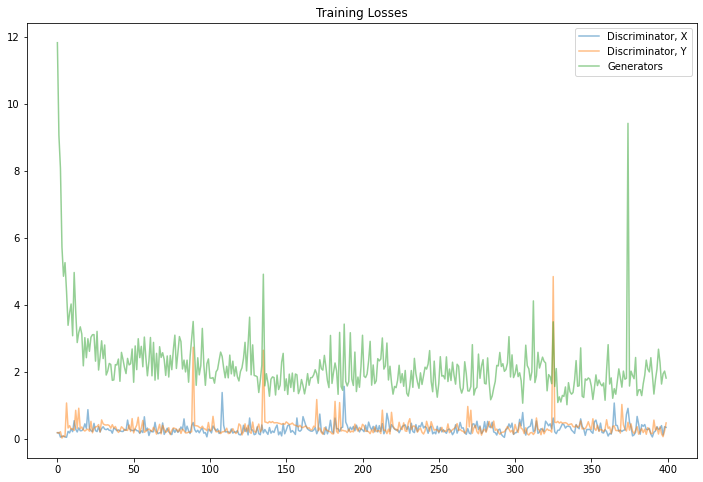

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [26]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


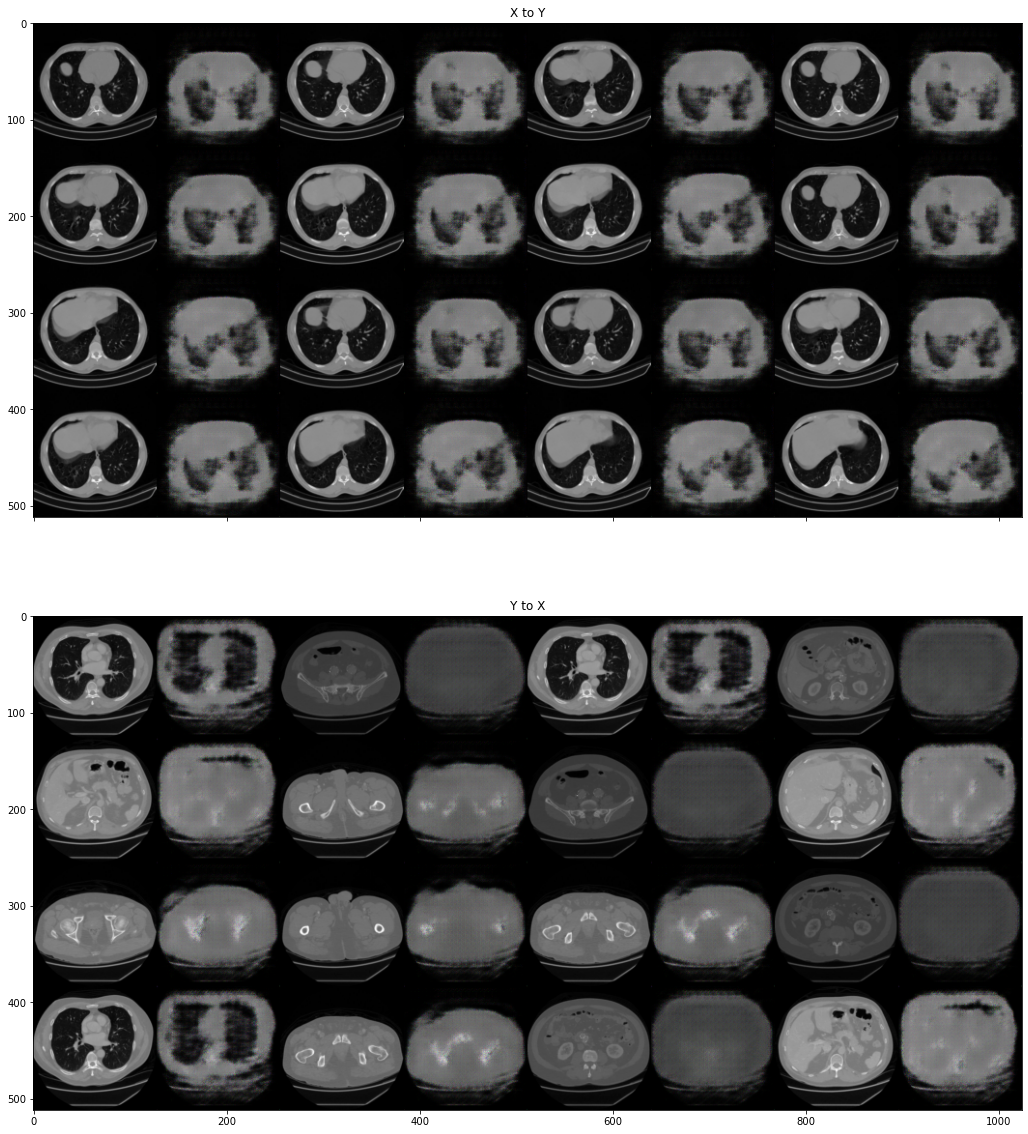

In [27]:
# view samples at iteration 100
view_samples(500, Params.path_samples)

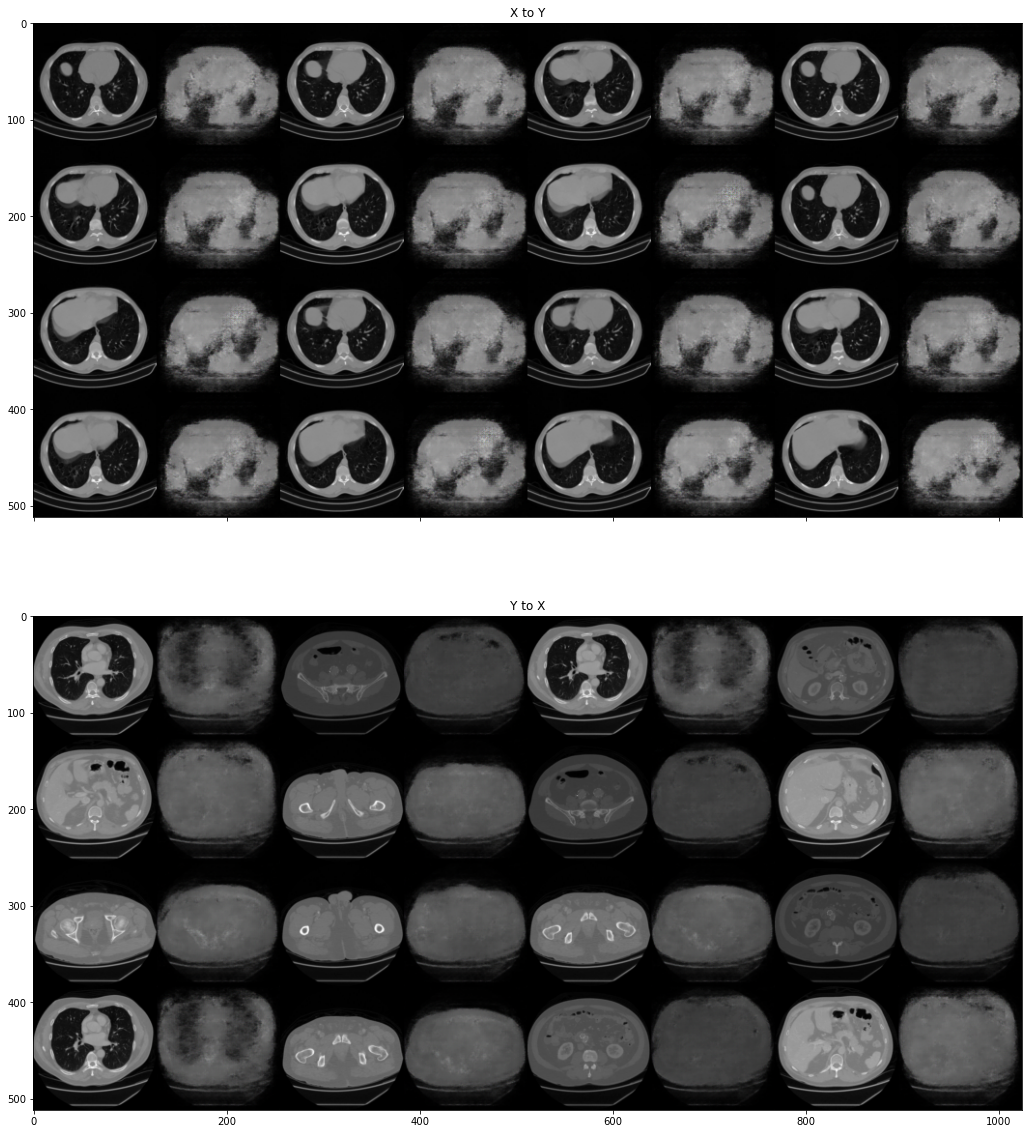

In [29]:
# view samples at iteration 4000
view_samples(4000, Params.path_samples)

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.